# Необходимые библиотеки

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=e7e3f42a4db4ab6236f9c3fdf2f13d23290131b34e18d74a6ca1e2a4d0e7ca30
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.8 MB/s 
     |████████████████████████████████| 2.8 MB 10.9 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
# core libraries
import numpy as np
import pandas as pd

# data downloading
import yfinance as yf

# visualization
import matplotlib.pyplot as plt
import pylab 
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
import plotly

# statistics
import scipy.stats as sps

# financial lib
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import figure

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
with open('drive/MyDrive/data/filename.txt') as file:
  tickers_new = file.read().split()

In [ ]:
tickers = pd.read_excel("drive/MyDrive/data/Spain_stocks_2017.xlsx")
tickers

,Category,Ticker
0,Money Center Banks,BBVA.MC
1,General Contractors,ANA.MC
2,Information Technology Services,AMS.MC
3,General Contractors,ABE.MC
4,Money Center Banks,SAN.MC
...,...,...
194,NaN,27447617.MC
195,Medical Instruments & Supplies,FAE.MC
196,NaN,TLGO.MC
197,Paper & Paper Products,RDM.MC


In [ ]:
len(list(set(tickers.Ticker) | set(tickers_new)))

283

In [ ]:
data = yf.download(list(set(tickers.Ticker) | set(tickers_new)), '2019-01-01', '2020-01-01')

[*********************100%***********************]  283 of 283 completed

110 Failed downloads:
- BIO.MC: No data found, symbol may be delisted
- YDOA.MC: No data found for this date range, symbol may be delisted
- GAS.MC: No data found for this date range, symbol may be delisted
- 27447617.MC: No data found, symbol may be delisted
- PRO.MC: Data doesn't exist for startDate = 1546300800, endDate = 1577836800
- QBT.MC: No data found, symbol may be delisted
- XUSI.MC: No data found for this date range, symbol may be delisted
- BAY.MC: No data found, symbol may be delisted
- YADR.MC: Data doesn't exist for startDate = 1546300800, endDate = 1577836800
- VOU.MC: No data found, symbol may be delisted
- RLI-D.MC: No data found, symbol may be delisted
- SNC.MC: No data found, symbol may be delisted
- 10641067.MA: No data found, symbol may be delisted
- AISA.MC: No data found, symbol may be delisted
- STG.MC: No data found for this date range, symbol may be delisted
- TR1.MC: Data doesn't exist

In [ ]:
indx = yf.download('^IBEX', '2019-01-01','2020-01-01')['Close']
indx

[*********************100%***********************]  1 of 1 completed


Date
2019-01-02    8550.000000
2019-01-03    8523.299805
2019-01-04    8737.799805
2019-01-07    8776.299805
2019-01-08    8847.299805
                 ...     
2019-12-23    9659.599609
2019-12-24    9661.799805
2019-12-27    9700.500000
2019-12-30    9612.599609
2019-12-31    9549.200195
Name: Close, Length: 255, dtype: float64

In [ ]:
df = data['Close']
df_volume = data['Volume']
df

,10641067.MA,27447617.MC,480S.MC,A3M.MC,ABB.MC,ABE.MC,ABG-P.MC,ABG.MC,ACS-D.MC,ACS.MC,ACX.MC,ADL.MC,ADV.MC,ADX.MC,ADZ.MC,AEDAS.MC,AENA.MC,AGIL.MC,AGS.MC,AI.MC,AIR.MC,AISA.MC,ALB.MC,ALC.MC,ALM.MC,ALNT.MC,ALQ.MC,AMEN.MC,AMP.MC,AMS.MC,ANA.MC,ANE.MC,APAM.MC,APPS.MC,ARM.MC,ART.MC,ATRY.MC,AXIA.MC,AZK.MC,BAIN.MC,...,XEKT.MC,XELTO.MC,XGGB.MC,XPBR.MC,XPBRA.MC,XTZA.MC,XUSI.MC,XUSIO.MC,XVALO.MC,YABA.MC,YAC1.MC,YADR.MC,YADV.MC,YAI1.MC,YAML.MC,YARE.MC,YATO.MC,YCPS.MC,YDOA.MC,YEIS.MC,YENT.MC,YFID.MC,YHAB.MC,YHCR.MC,YMEI.MC,YMPI.MC,YMRE.MC,YOSO.MC,YP3L.MC,YPMR.MC,YPR2.MC,YPR3.MC,YTRA.MC,YVBA.MC,YVCP.MC,YVIT.MC,YZBL.MC,YZPS.MC,ZNK.MC,ZOT.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,4.350,NaN,NaN,0.0037,0.0159,NaN,33.240002,8.582,1.63,NaN,1.400,6.90,22.040001,137.000000,1.46,NaN,0.1436,85.000000,NaN,41.150002,19.000000,13.154044,13.95,5.75,NaN,0.2550,61.439999,74.800003,NaN,22.420000,9.200,9.0,NaN,2.80,NaN,6.78,4.00,...,41.200001,5.557554,3.40,5.80,5.10,0.1060,NaN,2.64,11.5,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,32.799999,NaN,NaN,NaN,NaN,NaN,0.92,0.910,12.40,13.4,NaN,14.3,1.21,25.4,0.53,6.250
2019-01-03,NaN,NaN,NaN,4.278,NaN,NaN,0.0042,0.0170,NaN,33.320000,8.406,1.78,NaN,1.535,6.90,21.719999,137.050003,1.46,NaN,0.1426,81.199997,NaN,40.650002,19.000000,13.340001,13.95,5.75,NaN,0.2594,58.060001,76.339996,NaN,23.059999,9.140,9.0,NaN,2.82,NaN,6.80,3.72,...,42.200001,6.971318,3.40,6.25,5.65,0.1050,NaN,2.64,11.4,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,32.799999,NaN,NaN,NaN,NaN,NaN,0.92,0.910,12.00,13.4,NaN,14.3,1.21,25.4,0.53,6.135
2019-01-04,NaN,NaN,NaN,4.350,NaN,NaN,0.0042,0.0172,NaN,33.820000,8.882,1.80,NaN,1.800,6.98,22.059999,140.500000,1.46,NaN,0.1620,85.029999,NaN,41.950001,19.000000,13.496597,14.40,5.75,NaN,0.2650,60.060001,76.620003,NaN,24.150000,9.250,9.0,NaN,2.84,NaN,6.74,3.72,...,42.400002,7.020068,3.62,6.35,5.75,0.1080,NaN,2.64,12.1,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,32.799999,NaN,NaN,NaN,NaN,NaN,0.92,0.910,11.80,13.4,NaN,14.3,1.21,25.4,0.54,6.270
2019-01-07,NaN,NaN,NaN,4.430,NaN,NaN,0.0040,0.0169,NaN,33.930000,8.976,1.84,NaN,2.210,7.08,22.340000,139.149994,1.46,NaN,0.1668,83.139999,NaN,41.299999,19.000000,13.555320,14.10,5.75,NaN,0.2620,60.619999,77.139999,NaN,24.469999,9.445,9.0,NaN,2.88,NaN,6.74,3.72,...,44.000000,7.020068,3.64,6.55,5.80,0.1080,NaN,2.64,12.2,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,32.799999,NaN,NaN,NaN,NaN,NaN,0.92,0.925,11.80,13.4,NaN,14.3,1.21,25.4,0.54,6.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57,NaN
2019-12-27,NaN,NaN,NaN,3.522,NaN,NaN,0.0094,0.0188,NaN,35.189999,9.974,2.08,NaN,2.028,6.98,20.600000,175.050003,4.10,NaN,0.0794,133.020004,NaN,48.650002,21.000000,14.573193,15.50,5.85,NaN,0.2830,73.639999,94.500000,NaN,28.650000,11.460,11.4,NaN,5.10,NaN,6.72,3.04,...,66.500000,8.100000,4.38,7.20,6.70,0.0350,NaN,2.08,11.8,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.79,NaN,NaN,NaN,37.400002,NaN,NaN,NaN,NaN,NaN,0.76,0.690,

# Первичный аналз

## Пропущенные значения

In [ ]:
def plot_missing_values(df):
  plt.figure(figsize=(16, 8))
  plt.title('Missing Values Diagram')
  ax = sns.heatmap((df.isna()), cbar=False,yticklabels=False,cmap = 'viridis');

  for item in ax.get_xticklabels():
      item.set_rotation(90)

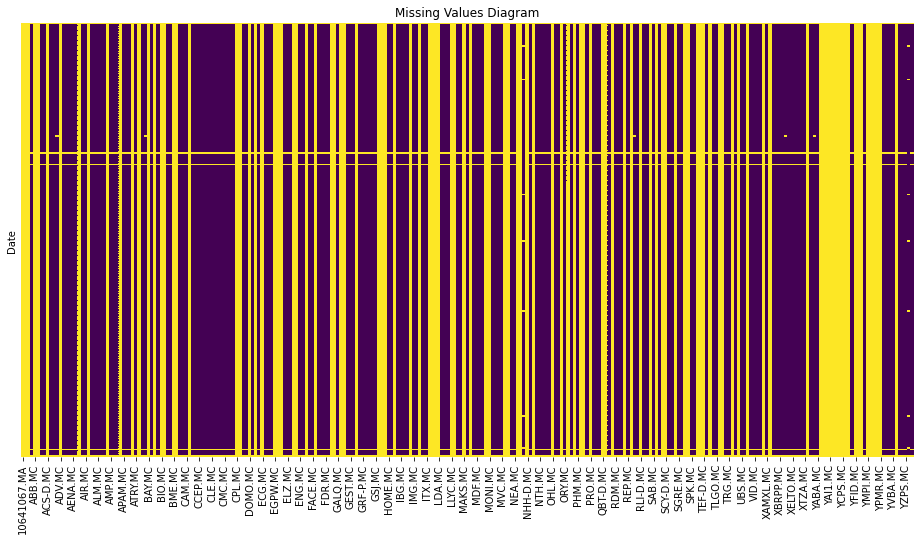

In [ ]:
plot_missing_values(df)

In [ ]:
df.shape[0], df.shape[1]

(261, 283)

### Удаление пропущенных значений





In [ ]:
df_cleaned = df.dropna(axis=0, thresh=int(df.shape[1]*0.25)).dropna(axis=1, thresh=int(df.shape[0]*0.25))
df.shape, df_cleaned.shape

((261, 283), (256, 173))

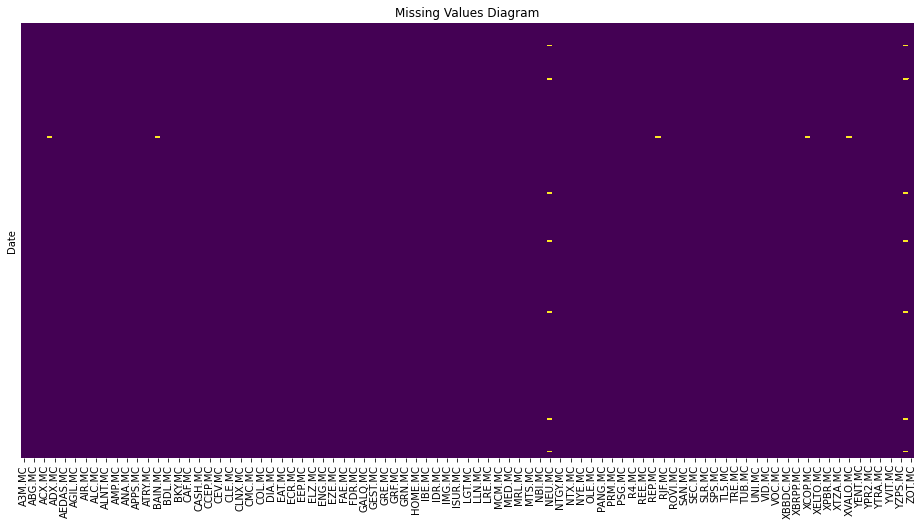

In [ ]:
plot_missing_values(df_cleaned)

### Заполнение пропущенных значений

In [ ]:
df_cleaned_filled = df_cleaned.interpolate()

In [ ]:
log_ret = np.log((df_cleaned_filled/df_cleaned_filled.shift(1)).dropna(how='all'))
index_logret = np.log((indx/indx.shift(1)).dropna(how='all'))
log_ret.head()

,A3M.MC,ABG-P.MC,ABG.MC,ACS.MC,ACX.MC,ADL.MC,ADX.MC,ADZ.MC,AEDAS.MC,AENA.MC,AGIL.MC,AI.MC,AIR.MC,ALB.MC,ALC.MC,ALM.MC,ALNT.MC,ALQ.MC,AMP.MC,AMS.MC,ANA.MC,APAM.MC,APPS.MC,ARM.MC,ATRY.MC,AZK.MC,BAIN.MC,BBVA.MC,BDL.MC,BKT.MC,BKY.MC,CABK.MC,CAF.MC,CAM.MC,CASH.MC,CBAV.MC,CCEP.MC,CDR.MC,CEV.MC,CIE.MC,...,SPK.MC,SPS.MC,TEF.MC,TL5.MC,TLGO.MC,TRE.MC,TRG.MC,TUB.MC,UBS.MC,UNI.MC,VER.MC,VID.MC,VIS.MC,VOC.MC,XAMXL.MC,XBBDC.MC,XBRK.MC,XBRPP.MC,XCMIG.MC,XCOP.MC,XEKT.MC,XELTO.MC,XGGB.MC,XPBR.MC,XPBRA.MC,XTZA.MC,XUSIO.MC,XVALO.MC,YABA.MC,YENT.MC,YMEI.MC,YPR2.MC,YPR3.MC,YTRA.MC,YVBA.MC,YVIT.MC,YZBL.MC,YZPS.MC,ZNK.MC,ZOT.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.016690,0.126752,0.066894,0.002404,-0.020721,0.088033,0.092058,0.000000,-0.014626,0.000365,0.0,-0.006988,-0.045736,-0.012225,0.000000,0.014038,0.000000,0.0,0.017108,-0.056584,0.020379,0.028146,-0.006543,0.000000,0.007117,0.002946,-0.072571,0.002677,0.004577,-0.005459,0.109518,-0.000639,-0.013793,0.0,0.042122,0.003752,0.009965,0.002920,0.0,-0.023754,...,0.014538,0.188271,0.016472,-0.003945,0.009407,-0.012934,0.084104,-0.025872,0.126752,-0.010573,0.196710,0.012089,-0.003000,0.000000,0.008032,0.054959,0.0,0.007326,-0.006154,0.000000,0.023982,0.226646,0.000000,0.074724,0.102415,-0.009479,0.0,-0.008734,0.0,0.0,0.0,0.0,0.000000,-0.032790,0.0,0.000000,0.0,0.0,0.000000,-0.018571
2019-01-04,0.016690,0.000000,0.011696,0.014895,0.055081,0.011173,0.159256,0.011527,0.015533,0.024862,0.0,0.127553,0.046089,0.031480,0.000000,0.011670,0.031749,0.0,0.021358,0.033867,0.003661,0.046185,0.011963,0.000000,0.007067,-0.008863,0.000000,0.036639,0.000000,0.030641,0.412357,0.037657,-0.008368,0.0,0.004016,0.007463,-0.025102,-0.011730,0.0,0.059719,...,0.045348,-0.056660,0.012932,0.014979,0.020390,0.033194,-0.020372,0.025872,0.023531,0.024498,-0.024098,0.001334,0.017865,0.000000,0.031499,0.021165,0.0,0.007273,0.012270,0.027588,0.004728,0.006969,0.062699,0.015873,0.017544,0.028171,0.0,0.059592,0.0,0.0,0.0,0.0,0.000000,-0.016807,0.0,0.000000,0.0,0.0,0.018692,0.021766
2019-01-07,0.018224,-0.048790,-0.017596,0.003247,0.010528,0.021979,0.205206,0.014225,0.012613,-0.009655,0.0,0.029199,-0.022478,-0.015616,0.000000,0.004341,-0.021053,0.0,-0.011385,0.009281,0.006764,0.013163,0.020862,0.000000,0.013986,0.000000,0.000000,-0.003511,-0.004577,-0.000559,-0.059423,0.005835,0.009756,0.0,-0.010071,-0.003724,0.007597,0.102258,0.0,-0.010929,...,0.033902,-0.040028,0.009006,0.036153,0.000000,-0.001400,0.040338,0.025220,0.000000,0.000000,0.024098,0.022414,0.003367,-0.018018,0.000000,0.000000,0.0,0.076693,-0.056441,0.000000,0.037041,0.000000,0.005510,0.031010,0.008658,0.000000,0.0,0.008230,0.0,0.0,0.0,0.0,0.016349,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.003185
2019-01-08,-0.000903,0.048790,0.023393,0.010262,0.024649,0.032088,-0.009091,-0.025752,-0.002689,0.006090,0.0,-0.035391,0.055219,0.016807,-0.005277,0.049306,-0.021506,0.0,0.011385,0.025087,0.014159,0.026614,0.058099,0.011050,-0.006969,-0.002972,0.000000,0.008447,0.000000,0.011397,-0.032596,0.001835,0.012405,0.0,0.034323,0.022141,0.016513,0.037888,0.0,0.027993,...,0.000000,-0.010557,-0.001560,-0.004105,-0.014788,0.021258,-0.029501,-0.001917,-0.023531,0.001727,0.011834,-0.014445,0.019555,0.000000,0.007722,0.000000,0.0,0.000000,0.000000,0.000000,0.022473,-0.013986,0.000000,0.000000,0.000000,-0.037740,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.007018,0.0,0.0,0.000000,0.052644
2019-01-09,0.048080,-0.024098,0.000000,0.008713,0.017456,0.051293,0.049008,-0.020499,-0.012647,-0.010772,0.0,-0.025159,0.020949,0.000000,0.000000,0.017036,0.010811,0.0,0.041395,0.004494,-0.007698,0.018921,-0.003503,-0.006615,-0.035591,0.008889,0.000000,0.013449,0.000000,-0.021512,0.094762,-0.007978,0.008186,0.0,0.002442,0.000000,0.000000,-0.012903,0.0,0.028097,...,0.004751,0.031343,-0.020644,0.018679,-0.009355,0.050813,0.054760,0.072187,0.000000,-0.026225,0.034686,0.019647,0.004522,0.000000,0.030305,0.000000,0.0,0.000000,0.012821,0.000000,0.0132

## Карта активов

In [ ]:
def plot_stocks_map(returns, mean_portfolio=True, index=False, index_ret=None, special=None):
  plt.figure(figsize=(16, 9))
  plt.title('Stocks Map')
  # подсчет доходностей и стандартных отклонений для акций
  mean_rets = returns.mean()
  std_rets = returns.std()
  # визуализация параметров акций
  ax = sns.scatterplot(x=std_rets, y=mean_rets);
  if mean_portfolio:
    # подсчет показателей портфеля
    n = returns.shape[1]
    r = [1/n for i in range(n)]
    cov = returns.cov()
    unif_portf = returns.mean(axis=1)
    portf_mean = unif_portf.mean()
    portf_std = unif_portf.std()
    # визуализация параметров портфеля
    plt.scatter(x=portf_std, y=portf_mean, c='r', marker='o', linewidths=5)
  if special:
    plt.scatter(x=returns[special].std(), y=returns[special].mean(), c='g', marker='o', linewidths=3)
  if index:
    # подсчет и визуализация показателей индекса
    plt.scatter(x=index_ret.std(), y=index_ret.mean(), c='b', marker='*', linewidths=5)
    
  ax.grid()
  ax.set_xlabel('Risk')
  ax.set_ylabel('Return')

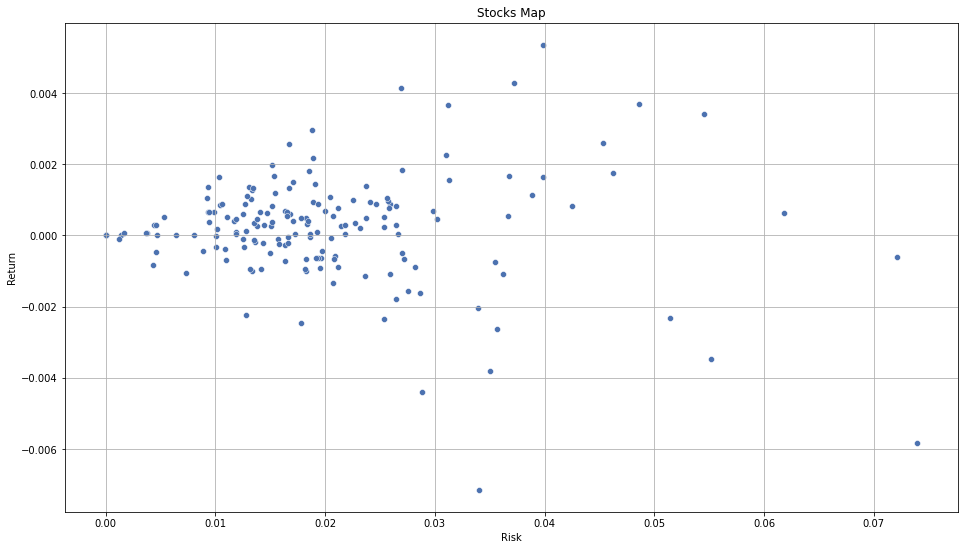

In [ ]:
plot_stocks_map(log_ret, index=False, mean_portfolio=False, index_ret=index_logret)

# Предобработка данных акций

In [ ]:
def preprocessing(df, **kwargs):
  default_kwargs = {'thresh' : 0.25, 'drop_non_liquid' : True, 'non_liquid_thresh' : 0.25}
  kwargs = { **default_kwargs, **kwargs }
  
  # dropping NAs (using threshold)
  df_cleaned = df.dropna(axis=0, thresh=int(df.shape[1]*kwargs['thresh'])).dropna(axis=1, thresh=int(df.shape[0]*kwargs['thresh']))
  # filling the rest NAs
  df_cleaned = df_cleaned.interpolate()
  # calculating log returns
  log_ret = np.log((df_cleaned/df_cleaned.shift(1)).dropna(how='all'))

  # dropping features with high rate of zeros
  if kwargs['drop_non_liquid']:
    cond = ((log_ret == 0).sum()/log_ret.shape[0] < kwargs['non_liquid_thresh'])
    log_ret = log_ret.T.where(cond, ).T.dropna(axis=1)
    df_cleaned = df_cleaned[log_ret.columns]
  return log_ret, df_cleaned

In [ ]:
log_ret, df_cleaned = preprocessing(df, **{'non_liquid_thresh' : 0.2})
log_ret.head(3)

,A3M.MC,ABG-P.MC,ABG.MC,ACS.MC,ACX.MC,ADX.MC,AEDAS.MC,AENA.MC,AI.MC,AIR.MC,ALB.MC,ALM.MC,AMP.MC,AMS.MC,ANA.MC,APPS.MC,AZK.MC,BBVA.MC,BKT.MC,BKY.MC,CABK.MC,CAF.MC,CASH.MC,CDR.MC,CIE.MC,CLNX.MC,CMC.MC,COL.MC,DIA.MC,DOM.MC,EBRO.MC,ECR.MC,EDR.MC,ELE.MC,ENC.MC,ENG.MC,ENO.MC,EZE.MC,FACE.MC,FAE.MC,...,MVC.MC,NEA.MC,NHH.MC,NTGY.MC,NTH.MC,NXT.MC,NYE.MC,OHLA.MC,OLE.MC,ORY.MC,PHM.MC,PRS.MC,PSG.MC,PVA.MC,RDM.MC,REE.MC,REN.MC,REP.MC,RLIA.MC,ROVI.MC,SAB.MC,SAN.MC,SCYR.MC,SGRE.MC,SLR.MC,SPK.MC,SPS.MC,TEF.MC,TL5.MC,TLGO.MC,TRE.MC,TRG.MC,TUB.MC,UNI.MC,VID.MC,VIS.MC,VOC.MC,XAMXL.MC,XTZA.MC,ZOT.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.016690,0.126752,0.066894,0.002404,-0.020721,0.092058,-0.014626,0.000365,-0.006988,-0.045736,-0.012225,0.014038,0.017108,-0.056584,0.020379,-0.006543,0.002946,0.002677,-0.005459,0.109518,-0.000639,-0.013793,0.042122,0.002920,-0.023754,0.011001,0.034726,0.002491,-0.009324,-0.017311,0.001716,-0.042044,0.004073,0.002985,-0.025975,0.012407,-0.011318,-0.005808,0.000000,-0.011657,...,-0.004515,0.056816,-0.010127,-0.008021,-0.040585,-0.017276,0.051885,-0.009807,0.137689,0.027890,0.013245,-0.001113,0.028645,-0.018018,0.009772,0.003034,-0.015798,0.001404,-0.018121,0.025679,-0.003402,0.008013,0.024761,-0.019338,-0.021379,0.014538,0.188271,0.016472,-0.003945,0.009407,-0.012934,0.084104,-0.025872,-0.010573,0.012089,-0.003000,0.000000,0.008032,-0.009479,-0.018571
2019-01-04,0.016690,0.000000,0.011696,0.014895,0.055081,0.159256,0.015533,0.024862,0.127553,0.046089,0.031480,0.011670,0.021358,0.033867,0.003661,0.011963,-0.008863,0.036639,0.030641,0.412357,0.037657,-0.008368,0.004016,-0.011730,0.059719,0.010449,0.051549,0.016652,-0.024443,0.004646,0.009101,0.011643,0.033969,0.003471,0.058411,0.002053,0.004866,0.051099,0.018692,0.018258,...,0.011696,0.037094,0.010127,0.008021,0.032599,0.018592,0.022223,0.101876,0.028632,0.029044,0.066797,-0.020248,0.044276,-0.029210,0.094278,-0.013983,0.034432,0.023571,0.011364,0.013986,0.045463,0.036728,0.036162,0.040096,0.104760,0.045348,-0.056660,0.012932,0.014979,0.020390,0.033194,-0.020372,0.025872,0.024498,0.001334,0.017865,0.000000,0.031499,0.028171,0.021766
2019-01-07,0.018224,-0.048790,-0.017596,0.003247,0.010528,0.205206,0.012613,-0.009655,0.029199,-0.022478,-0.015616,0.004341,-0.011385,0.009281,0.006764,0.020862,0.000000,-0.003511,-0.000559,-0.059423,0.005835,0.009756,-0.010071,0.102258,-0.010929,0.028183,0.041276,0.014572,0.004258,-0.011655,0.000566,0.085027,0.019456,0.003459,0.001772,-0.000821,0.011263,0.021899,-0.025001,-0.003295,...,0.000894,-0.034191,-0.010127,0.002660,0.035999,0.051293,0.021740,-0.018495,-0.073901,0.087647,0.099497,-0.009133,-0.011212,-0.015724,-0.040638,-0.002564,0.012233,-0.008256,0.022347,0.005540,0.003346,0.005634,0.005287,0.002676,0.047502,0.033902,-0.040028,0.009006,0.036153,0.000000,-0.001400,0.040338,0.025220,0.000000,0.022414,0.003367,-0.018018,0.000000,0.000000,0.003185


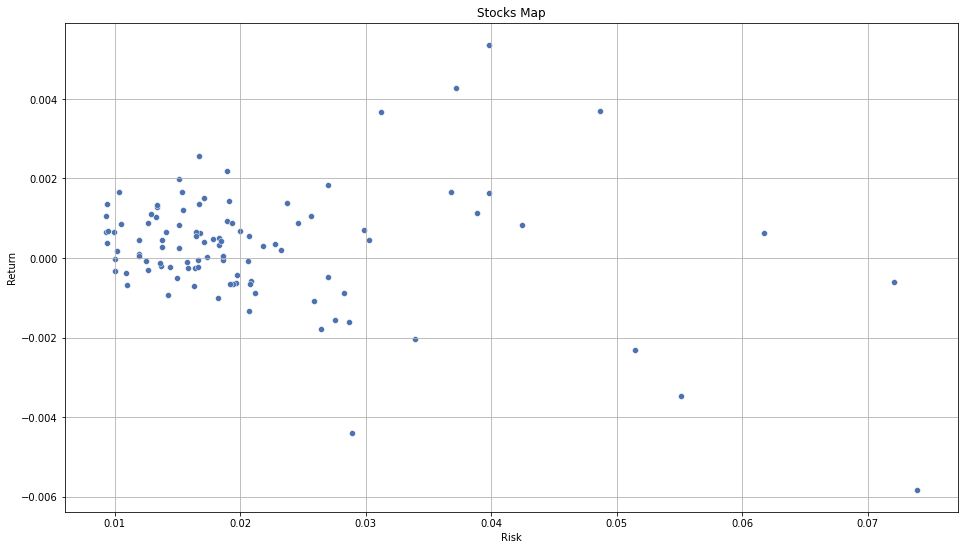

In [ ]:
plot_stocks_map(log_ret, index=False, mean_portfolio=False, index_ret=index_logret)

# Характеристики акций. Отбор наилучших (к заданию 1)

С помощью коэффициента Шарпа выберем 50 акций.

In [ ]:
df_stock_info = pd.DataFrame()
df_stock_info['mean'] = log_ret.mean()
df_stock_info['std'] = log_ret.std()
df_stock_info['sharpe'] = log_ret.mean()/log_ret.std()
best50 = df_stock_info['sharpe'].sort_values(ascending=False)[:50].index
df_stock_info

,mean,std,sharpe
A3M.MC,-0.000873,0.021134,-0.041299
ABG-P.MC,0.003698,0.048638,0.076028
ABG.MC,0.000699,0.029856,0.023396
ACS.MC,0.000274,0.013765,0.019941
ACX.MC,0.000617,0.016817,0.036706
...,...,...,...
VIS.MC,0.000030,0.017302,0.001739
VOC.MC,0.000351,0.022766,0.015436
XAMXL.MC,0.000559,0.020724,0.026977
XTZA.MC,-0.004402,0.028870,-0.152471


In [ ]:
best50

Index(['FER.MC', 'CLNX.MC', 'COL.MC', 'FACE.MC', 'FAE.MC', 'GRE.MC', 'PHM.MC',
       'EDR.MC', 'IBE.MC', 'AIR.MC', 'ITX.MC', 'GRF.MC', 'SCYR.MC', 'VID.MC',
       'AENA.MC', 'ROVI.MC', 'SPK.MC', 'GRF-P.MC', 'ABG-P.MC', 'NEA.MC',
       'MRL.MC', 'ANA.MC', 'ALB.MC', 'SLR.MC', 'ELE.MC', 'SGRE.MC', 'APPS.MC',
       'FDR.MC', 'AMS.MC', 'IDR.MC', 'ADX.MC', 'RDM.MC', 'EBRO.MC', 'OHLA.MC',
       'NHH.MC', 'ZOT.MC', 'ACX.MC', 'GSJ.MC', 'NXT.MC', 'TLGO.MC', 'CAF.MC',
       'SPS.MC', 'TRE.MC', 'XAMXL.MC', 'NTH.MC', 'ABG.MC', 'AMP.MC', 'TUB.MC',
       'ACS.MC', 'TRG.MC'],
      dtype='object')

In [ ]:
log_ret50 = log_ret[best50]
log_ret50.head(3)

,FER.MC,CLNX.MC,COL.MC,FACE.MC,FAE.MC,GRE.MC,PHM.MC,EDR.MC,IBE.MC,AIR.MC,ITX.MC,GRF.MC,SCYR.MC,VID.MC,AENA.MC,ROVI.MC,SPK.MC,GRF-P.MC,ABG-P.MC,NEA.MC,MRL.MC,ANA.MC,ALB.MC,SLR.MC,ELE.MC,SGRE.MC,APPS.MC,FDR.MC,AMS.MC,IDR.MC,ADX.MC,RDM.MC,EBRO.MC,OHLA.MC,NHH.MC,ZOT.MC,ACX.MC,GSJ.MC,NXT.MC,TLGO.MC,CAF.MC,SPS.MC,TRE.MC,XAMXL.MC,NTH.MC,ABG.MC,AMP.MC,TUB.MC,ACS.MC,TRG.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.005069,0.011001,0.002491,0.000000,-0.011657,0.008439,0.013245,0.004073,0.001713,-0.045736,-0.014369,0.003513,0.024761,0.012089,0.000365,0.025679,0.014538,0.007453,0.126752,0.056816,-0.008392,0.020379,-0.012225,-0.021379,0.002985,-0.019338,-0.006543,-0.014691,-0.056584,-0.015504,0.092058,0.009772,0.001716,-0.009807,-0.010127,-0.018571,-0.020721,0.010384,-0.017276,0.009407,-0.013793,0.188271,-0.012934,0.008032,-0.040585,0.066894,0.017108,-0.025872,0.002404,0.084104
2019-01-04,0.012006,0.010449,0.016652,0.018692,0.018258,0.016667,0.066797,0.033969,0.007391,0.046089,0.034670,0.032776,0.036162,0.001334,0.024862,0.013986,0.045348,0.032870,0.000000,0.037094,0.010710,0.003661,0.031480,0.104760,0.003471,0.040096,0.011963,-0.006363,0.033867,0.025302,0.159256,0.094278,0.009101,0.101876,0.010127,0.021766,0.055081,0.027511,0.018592,0.020390,-0.008368,-0.056660,0.033194,0.031499,0.032599,0.011696,0.021358,0.025872,0.014895,-0.020372
2019-01-07,0.007466,0.028183,0.014572,-0.025001,-0.003295,0.160036,0.099497,0.019456,0.007618,-0.022478,0.007833,-0.000849,0.005287,0.022414,-0.009655,0.005540,0.033902,0.000000,-0.048790,-0.034191,0.001389,0.006764,-0.015616,0.047502,0.003459,0.002676,0.020862,0.007419,0.009281,-0.019072,0.205206,-0.040638,0.000566,-0.018495,-0.010127,0.003185,0.010528,0.053803,0.051293,0.000000,0.009756,-0.040028,-0.001400,0.000000,0.035999,-0.017596,-0.011385,0.025220,0.003247,0.040338


In [ ]:
df_best_50 = df_cleaned[best50].dropna(axis=0)
df_best_50.head(3)

,FER.MC,CLNX.MC,COL.MC,FACE.MC,FAE.MC,GRE.MC,PHM.MC,EDR.MC,IBE.MC,AIR.MC,ITX.MC,GRF.MC,SCYR.MC,VID.MC,AENA.MC,ROVI.MC,SPK.MC,GRF-P.MC,ABG-P.MC,NEA.MC,MRL.MC,ANA.MC,ALB.MC,SLR.MC,ELE.MC,SGRE.MC,APPS.MC,FDR.MC,AMS.MC,IDR.MC,ADX.MC,RDM.MC,EBRO.MC,OHLA.MC,NHH.MC,ZOT.MC,ACX.MC,GSJ.MC,NXT.MC,TLGO.MC,CAF.MC,SPS.MC,TRE.MC,XAMXL.MC,NTH.MC,ABG.MC,AMP.MC,TUB.MC,ACS.MC,TRG.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,17.709999,19.919350,8.020,0.795,3.020,5.90,14.400057,2.450,6.998,85.000000,22.430000,22.730000,1.7750,63.923981,137.000000,17.299999,9.56,16.040001,0.0037,3.25,10.770,74.800003,41.150002,4.255,20.070000,10.965,9.20,9.60,61.439999,8.125,1.400,0.611,17.469999,0.6968,3.97,6.250,8.582,4.790,0.750785,5.29,36.500000,0.391,21.010000,0.620,1.760,0.0159,0.2550,2.545,33.240002,0.1550
2019-01-03,17.799999,20.139696,8.040,0.795,2.985,5.95,14.592058,2.460,7.010,81.199997,22.110001,22.809999,1.8195,64.701439,137.050003,17.750000,9.70,16.160000,0.0042,3.44,10.680,76.339996,40.650002,4.165,20.129999,10.755,9.14,9.46,58.060001,8.000,1.535,0.617,17.500000,0.6900,3.93,6.135,8.406,4.840,0.737926,5.34,36.000000,0.472,20.740000,0.625,1.690,0.0170,0.2594,2.480,33.320000,0.1686
2019-01-04,18.014999,20.351231,8.175,0.810,3.040,6.05,15.600062,2.545,7.062,85.029999,22.889999,23.570000,1.8865,64.787819,140.500000,18.000000,10.15,16.700001,0.0042,3.57,10.795,76.620003,41.950001,4.625,20.200001,11.195,9.25,9.40,60.060001,8.205,1.800,0.678,17.660000,0.7640,3.97,6.270,8.882,4.975,0.751774,5.45,35.700001,0.446,21.440001,0.645,1.746,0.0172,0.2650,2.545,33.820000,0.1652


# Сокращение количества акций (к заданию 2)

Для выделения 10 акций из 50 используется максимальное независимое множество.

In [ ]:
!pip install igraph

     |████████████████████████████████| 3.2 MB 5.1 MB/s 


In [ ]:
import igraph

In [ ]:
def calc_weights_sum(table, indicies):
  indicies_copy = indicies.copy()
  sum = 0
  for i in sorted(indicies):
    indicies_copy.remove(i)
    for j in indicies_copy:
      sum += table[i][j]
  return sum

In [ ]:
g = igraph.Graph()
corr_table = np.abs(log_ret50.corr().values)
thresh = 0.1

for i in range(corr_table.shape[0]):
  g.add_vertex(i)

for i in range(0, corr_table.shape[0] - 1):
  for j in range(i+1, corr_table.shape[0]):
    if corr_table[i][j] > thresh:
      g.add_edge(i, j)

In [ ]:
unique = set()
for s in g.maximal_independent_vertex_sets():
  unique.add(len(s))
print(unique)

{3, 4, 5, 6, 7, 8, 9, 10}


In [ ]:
mis10 = list(filter(lambda x: len(x) == 10, g.maximal_independent_vertex_sets()))
mis10[:5]

[(1, 3, 5, 15, 19, 27, 33, 41, 43, 45),
 (1, 3, 5, 15, 19, 33, 38, 41, 43, 45),
 (1, 3, 5, 15, 19, 33, 38, 41, 45, 47),
 (1, 3, 5, 15, 19, 27, 34, 41, 43, 45),
 (1, 3, 5, 15, 19, 34, 38, 41, 43, 45)]

In [ ]:
min_weights_sum = np.inf
min_max_ind_set = []

for max_ind_set in mis10:
  weights_sum = calc_weights_sum(corr_table, list(max_ind_set))
  if weights_sum < min_weights_sum:
    min_max_ind_set = max_ind_set
    min_weights_sum = weights_sum
    print(min_weights_sum)

1.621547774729193
1.5657186878423073


In [ ]:
res = list(min_max_ind_set)
res

[1, 3, 5, 15, 19, 33, 38, 41, 43, 45]

# Эффективные границы (Задание 1 и 2)

In [ ]:
from pypfopt.expected_returns import returns_from_prices, mean_historical_return

In [ ]:
log_ret50

,FER.MC,CLNX.MC,COL.MC,FACE.MC,FAE.MC,GRE.MC,PHM.MC,EDR.MC,IBE.MC,AIR.MC,ITX.MC,GRF.MC,SCYR.MC,VID.MC,AENA.MC,ROVI.MC,SPK.MC,GRF-P.MC,ABG-P.MC,NEA.MC,MRL.MC,ANA.MC,ALB.MC,SLR.MC,ELE.MC,SGRE.MC,APPS.MC,FDR.MC,AMS.MC,IDR.MC,ADX.MC,RDM.MC,EBRO.MC,OHLA.MC,NHH.MC,ZOT.MC,ACX.MC,GSJ.MC,NXT.MC,TLGO.MC,CAF.MC,SPS.MC,TRE.MC,XAMXL.MC,NTH.MC,ABG.MC,AMP.MC,TUB.MC,ACS.MC,TRG.MC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.005069,0.011001,0.002491,0.000000,-0.011657,0.008439,0.013245,0.004073,0.001713,-0.045736,-0.014369,0.003513,0.024761,0.012089,0.000365,0.025679,0.014538,0.007453,0.126752,0.056816,-0.008392,0.020379,-0.012225,-0.021379,0.002985,-0.019338,-0.006543,-0.014691,-0.056584,-0.015504,0.092058,0.009772,0.001716,-0.009807,-0.010127,-0.018571,-0.020721,0.010384,-0.017276,0.009407,-0.013793,0.188271,-0.012934,0.008032,-0.040585,0.066894,0.017108,-0.025872,0.002404,0.084104
2019-01-04,0.012006,0.010449,0.016652,0.018692,0.018258,0.016667,0.066797,0.033969,0.007391,0.046089,0.034670,0.032776,0.036162,0.001334,0.024862,0.013986,0.045348,0.032870,0.000000,0.037094,0.010710,0.003661,0.031480,0.104760,0.003471,0.040096,0.011963,-0.006363,0.033867,0.025302,0.159256,0.094278,0.009101,0.101876,0.010127,0.021766,0.055081,0.027511,0.018592,0.020390,-0.008368,-0.056660,0.033194,0.031499,0.032599,0.011696,0.021358,0.025872,0.014895,-0.020372
2019-01-07,0.007466,0.028183,0.014572,-0.025001,-0.003295,0.160036,0.099497,0.019456,0.007618,-0.022478,0.007833,-0.000849,0.005287,0.022414,-0.009655,0.005540,0.033902,0.000000,-0.048790,-0.034191,0.001389,0.006764,-0.015616,0.047502,0.003459,0.002676,0.020862,0.007419,0.009281,-0.019072,0.205206,-0.040638,0.000566,-0.018495,-0.010127,0.003185,0.010528,0.053803,0.051293,0.000000,0.009756,-0.040028,-0.001400,0.000000,0.035999,-0.017596,-0.011385,0.025220,0.003247,0.040338
2019-01-08,0.009596,-0.002107,0.020287,0.000000,0.000000,-0.057987,-0.021113,-0.003861,-0.003660,0.055219,0.021442,0.014753,0.004734,-0.014445,0.006090,0.013718,0.000000,0.008348,0.048790,-0.017544,0.022863,0.014159,0.016807,-0.034613,0.005412,0.018098,0.058099,-0.002114,0.025087,0.016631,-0.009091,0.013730,-0.006814,0.086789,0.021149,0.052644,0.024649,-0.017292,0.006231,-0.014788,0.012405,-0.010557,0.021258,0.007722,-0.020090,0.023393,0.011385,-0.001917,0.010262,-0.029501
2019-01-09,0.004356,0.000422,-0.005330,0.067304,-0.008285,0.014815,0.007087,0.011539,-0.032395,0.020949,0.011390,0.013713,0.037342,0.019647,-0.010772,0.010840,0.004751,0.010632,-0.024098,-0.002954,-0.014572,-0.007698,0.000000,0.001067,-0.013834,0.019494,-0.003503,-0.002119,0.004494,0.047131,0.049008,0.016529,-0.002282,-0.028017,0.021686,-0.001509,0.017456,0.017292,-0.022614,-0.009355,0.008186,0.031343,0.050813,0.030305,0.021194,0.000000,0.041395,0.072187,0.008713,0.054760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.005534,-0.003120,0.000000,0.060830,0.009681,0.034368,0.028520,-0.014617,-0.003670,0.000901,0.003468,0.000313,-0.013616,-0.006565,0.002880,0.020791,0.000000,-0.002384,-0.020834,0.050937,-0.000782,0.005944,-0.004145,0.011835,0.002384,-0.002866,0.010629,0.010067,0.012836,0.000989,0.012079,-0.009877,0.002544,0.004303,0.005452,-0.007138,-0.003815,-0.032485,0.013275,0.001646,-0.007426,-0.036634,0.000000,-0.006873,0.000000,-0.021165,-0.014035,-0.003478,0.016529,-0.008360
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-27,-0.001473,0.018576,0.017498,0.131891,-0.01

In [ ]:
best10 = best50[res]
best10

Index(['CLNX.MC', 'FACE.MC', 'GRE.MC', 'ROVI.MC', 'NEA.MC', 'OHLA.MC',
       'NXT.MC', 'SPS.MC', 'XAMXL.MC', 'ABG.MC'],
      dtype='object')

In [ ]:
df_best_10 = df[best10].dropna(axis=0)
df_best_10.head()

,CLNX.MC,FACE.MC,GRE.MC,ROVI.MC,NEA.MC,OHLA.MC,NXT.MC,SPS.MC,XAMXL.MC,ABG.MC
Date,,,,,,,,,,
2019-01-02,19.919350,0.795,5.90,17.299999,3.25,0.6968,0.750785,0.3910,0.620,0.0159
2019-01-03,20.139696,0.795,5.95,17.750000,3.44,0.6900,0.737926,0.4720,0.625,0.0170
2019-01-04,20.351231,0.810,6.05,18.000000,3.57,0.7640,0.751774,0.4460,0.645,0.0172
2019-01-07,20.932945,0.790,7.10,18.100000,3.45,0.7500,0.791341,0.4285,0.645,0.0169
2019-01-08,20.888876,0.790,6.70,18.350000,3.39,0.8180,0.796287,0.4240,0.650,0.0173


In [ ]:
df_best_10.shape

(256, 10)

In [ ]:
risk=risk_models.risk_matrix(df_best_50)

In [ ]:
#Годовая доходность
mu50 = expected_returns.mean_historical_return(df_best_50, compounding=False, frequency=256, log_returns=True) 
#Дисперсия портфеля
Sigma50 = risk_models.sample_cov(df_best_50, frequency=256, log_returns=True)
ef50 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))


In [ ]:
muindex = expected_returns.mean_historical_return(indx.to_frame(), compounding=False, frequency=256, log_returns=True)['Close']
stdindex = np.sqrt(risk_models.sample_cov(indx.to_frame(), frequency=256, log_returns=True)['Close']['Close'])
muindex, stdindex

(0.11139640325530682, 0.12534292290441154)

In [ ]:
mu10 = expected_returns.mean_historical_return(df_best_10, compounding=False, frequency=256, log_returns=True) 

Sigma10 = risk_models.sample_cov(df_best_10, compounding=False, frequency=256, log_returns=True)
ef10 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))

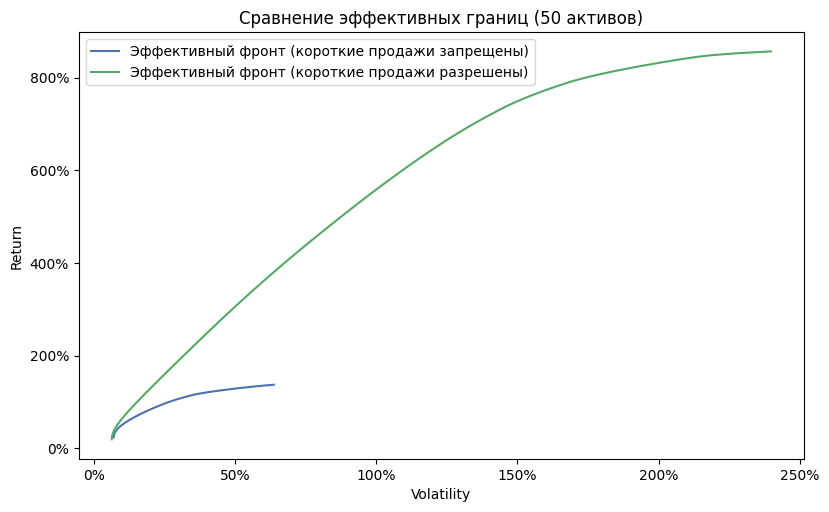

In [ ]:
figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи запрещены)', 'Эффективный фронт (короткие продажи разрешены)'])
ax.set_title('Сравнение эффективных границ (50 активов)');

Эффективный фронт, в ситуации когда короткие продажи запрещены, находится ниже, чем эффективный фронт с разрешенными короткими продажами и ограничен.

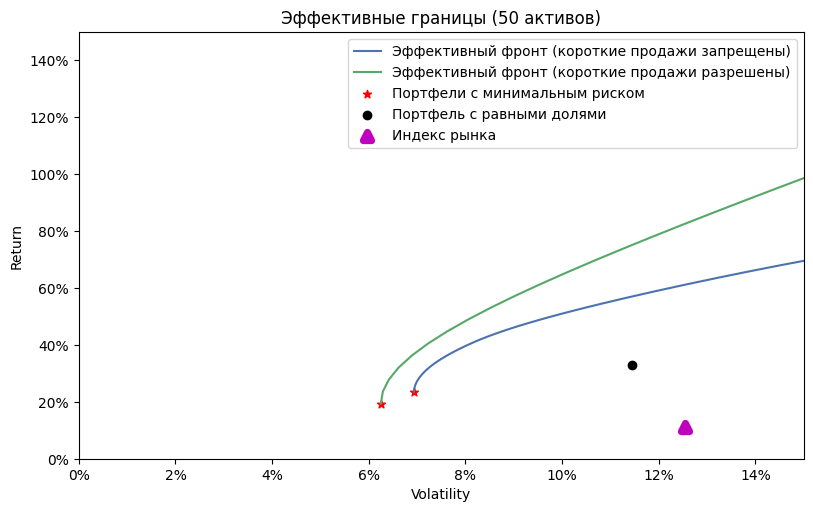

In [ ]:
w_50=EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1)).min_volatility()
for el in w_50:
  w_50[el]=1/50


figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))
ef500.min_volatility()
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r", label="Min Vol 0/1")

ef500.set_weights(w_50)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", c="k", label="EQ W 0/1")


ax = plt.scatter(x=stdindex, y=muindex, c='m', marker='^', linewidths=5)

ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))
ef500.min_volatility()
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r", label="Min Vol -1/1")


ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи запрещены)', 'Эффективный фронт (короткие продажи разрешены)', "Портфели с минимальным риском", "Портфель с равными долями","Индекс рынка"]);
plt.ylim((0,1.5))
plt.xlim((0,0.15))
ax.set_title('Эффективные границы (50 активов)');

In [ ]:
muindex, stdindex

(0.11139640325530682, 0.12534292290441154)

Портфель с ранвыми долями и индекс рынка находятся рядом с эффективным фронтом, имея низкую волатильность. Порфтели с минимальным риском находятся на нижних концах соответствующих эффективных фронтов. 

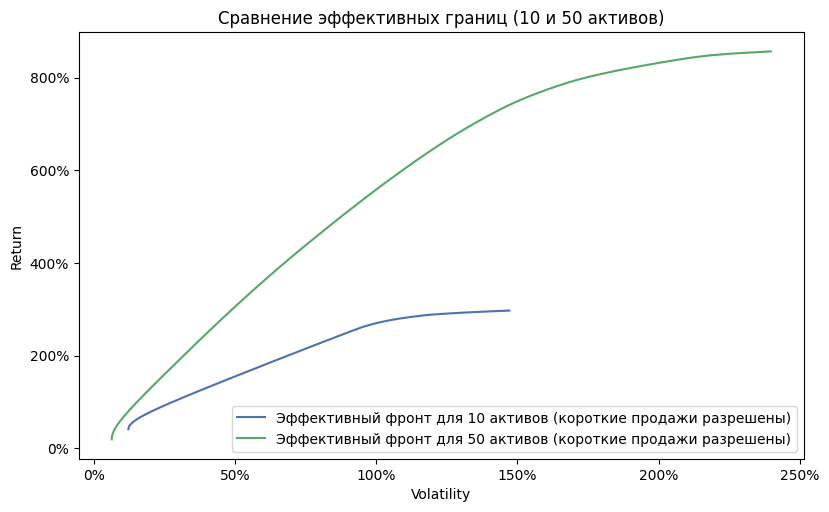

In [ ]:
figure(figsize=(8, 5), dpi=100)
ef10 = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1))
ax = pplt.plot_efficient_frontier(ef10, showfig = False, points=300, show_assets=False)
ef50 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1, 1))
ax = pplt.plot_efficient_frontier(ef50, showfig = False, points=200, show_assets=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт для 10 активов (короткие продажи разрешены)', 'Эффективный фронт для 50 активов (короткие продажи разрешены)'])
ax.set_title('Сравнение эффективных границ (10 и 50 активов)');

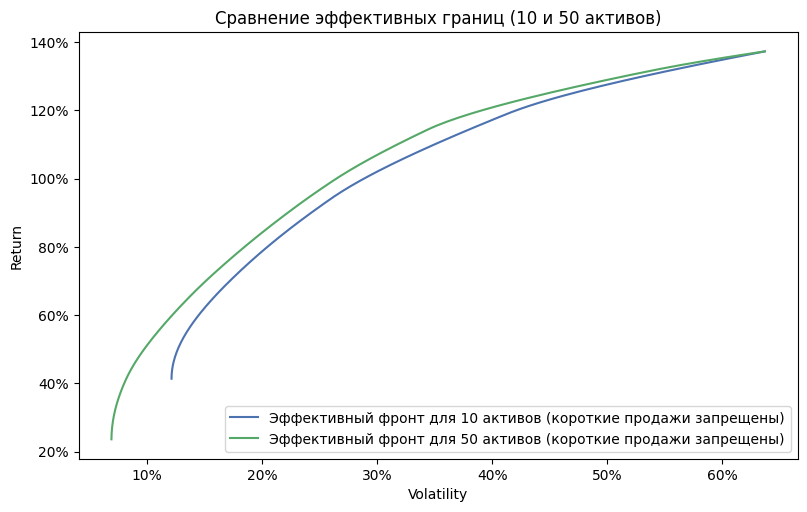

In [ ]:
figure(figsize=(8, 5), dpi=100)
ef10 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0, 1))
ax = pplt.plot_efficient_frontier(ef10, showfig = False, points=200, show_assets=False)
ef50 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0, 1))
ax = pplt.plot_efficient_frontier(ef50, showfig = False, points=200, show_assets=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт для 10 активов (короткие продажи запрещены)', 'Эффективный фронт для 50 активов (короткие продажи запрещены)'])
ax.set_title('Сравнение эффективных границ (10 и 50 активов)');

# Отношение в риску. Составление портфеля с заданным отвращением к риску. (Задание 3)

In [ ]:
result=pd.DataFrame(columns=['Return (Annualised)','Std (Annualised)','VaR'], index=['Max UF 50 Shorts Allowed', 'Max UF 50 Shorts Not Allowed','Max UF 10 Shorts Allowed', 'Max UF 10 Shorts Not Allowed', 
                                                                                     'Sharp Portfolio Shorts Allowed','Sharp Portfolio Shorts Not Allowed'])


## 50 активов (короткие продажи запрещены)


In [ ]:
def calc_var(returns, alpha=0.05):
  param_VaR = -(returns.mean() + returns.std()*sps.norm.ppf(alpha))
  hist_VaR = -returns.quantile(alpha)
  
  return param_VaR, hist_VaR

In [ ]:
ef = EfficientFrontier(mu50, Sigma50, weight_bounds=(0, 1), )
cl_obj = CLA(mu50, Sigma50, weight_bounds=(0, 1), )
rets, sigmas, weights = cl_obj.efficient_frontier(points=8000, )
rets = np.array(rets)
sigmas = np.array(sigmas)
weights = np.array(weights)

In [ ]:
a = 1.5
rets = np.array(rets)
sigmas = np.array(sigmas)
util_fun = rets - a*sigmas
max_ind, max_val = util_fun.argmax(), util_fun.max()
max_ind, max_val

(789, 0.627431712524744)

In [ ]:
chosen_portf_weigths = weights[max_ind]
chosen_portf_weigths = [x for l in chosen_portf_weigths for x in l]

In [ ]:
ef50=EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))
w_50=EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1)).min_volatility()
for name, weight in zip(w_50, chosen_portf_weigths):
  w_50[name] = weight

ef50.set_weights(w_50)
print(w_50)


OrderedDict([('FER.MC', 0.0), ('CLNX.MC', 2.1423399068143723e-16), ('COL.MC', 0.0), ('FACE.MC', 0.4123069962299561), ('FAE.MC', 0.0), ('GRE.MC', 0.29589906570859514), ('PHM.MC', 0.1877320823843777), ('EDR.MC', 0.0), ('IBE.MC', 0.0), ('AIR.MC', 0.0), ('ITX.MC', 0.0), ('GRF.MC', 0.0), ('SCYR.MC', 0.0), ('VID.MC', 0.0), ('AENA.MC', 0.0), ('ROVI.MC', 0.0), ('SPK.MC', 0.0), ('GRF-P.MC', 0.0), ('ABG-P.MC', 0.1040618556770714), ('NEA.MC', 0.0), ('MRL.MC', 0.0), ('ANA.MC', 0.0), ('ALB.MC', 0.0), ('SLR.MC', 0.0), ('ELE.MC', 0.0), ('SGRE.MC', 0.0), ('APPS.MC', 0.0), ('FDR.MC', 0.0), ('AMS.MC', 0.0), ('IDR.MC', 0.0), ('ADX.MC', 0.0), ('RDM.MC', 0.0), ('EBRO.MC', 0.0), ('OHLA.MC', 0.0), ('NHH.MC', 0.0), ('ZOT.MC', 0.0), ('ACX.MC', 0.0), ('GSJ.MC', 0.0), ('NXT.MC', 0.0), ('TLGO.MC', 0.0), ('CAF.MC', 0.0), ('SPS.MC', 0.0), ('TRE.MC', 0.0), ('XAMXL.MC', 0.0), ('NTH.MC', 0.0), ('ABG.MC', 0.0), ('AMP.MC', 0.0), ('TUB.MC', 0.0), ('ACS.MC', 0.0), ('TRG.MC', 0.0)])


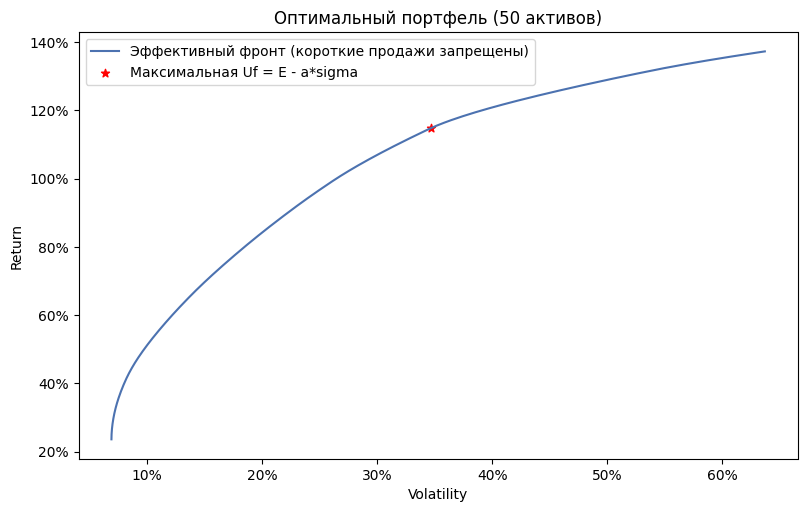

In [ ]:
figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=300, show_assets=False)
ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(0,1))

ef500.set_weights(w_50)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r")

# ef500.max_quadratic_utility(risk_aversion=a)
# ret_tangent, std_tangent, _ = ef500.portfolio_performance()
# ax.scatter(std_tangent, ret_tangent, marker="*", c="g")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи запрещены)', 'Максимальная Uf = E - a*sigma','Максимальная Квадратичная Uf']);
ax.set_title('Оптимальный портфель (50 активов)');

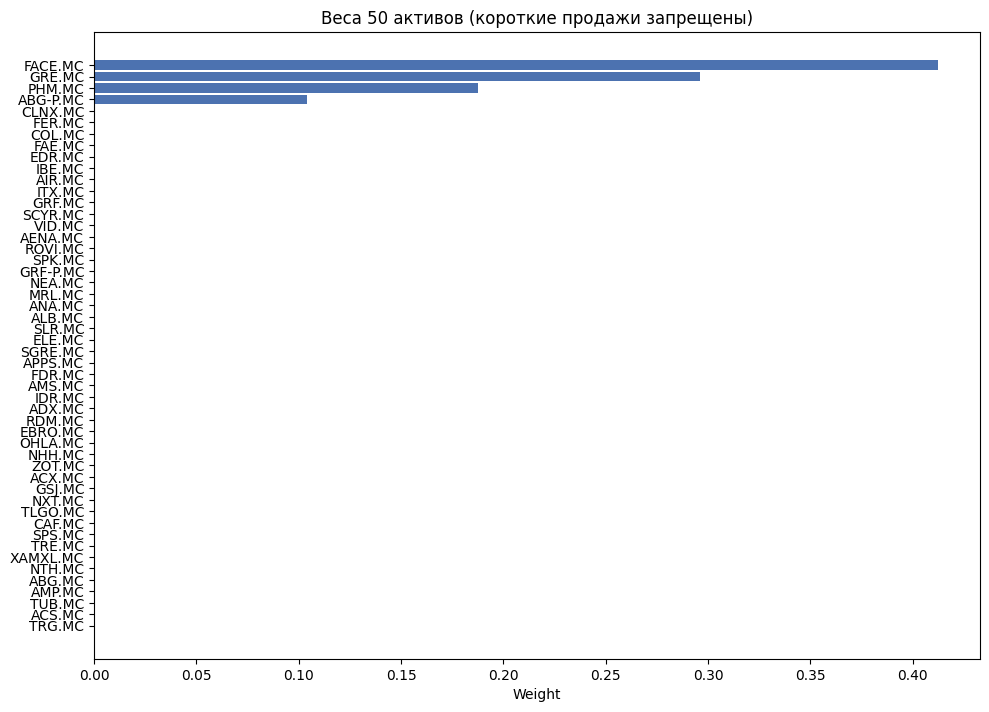

In [ ]:
figure(figsize=(10, 7), dpi=100)
ax=pplt.plot_weights(w_50);
ax.set_title('Веса 50 активов (короткие продажи запрещены)');

FACE.MC - Facephi Biometria (разработка и маркетинг программного обеспечения для распознавания лиц)

GRE.MC - Grenergy Renovables (разработчик и производитель возобновляемой энергии)

PHM.MC - Pharma Mar (фармацевтическая компания)

ABG-P.MC - ABENGOA CLASE B (технологические решения для обеспечения устойчивости в секторе энергетики и окружающей среды)

In [ ]:
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_50, log_returns=True)).dot(chosen_portf_weigths))
param_VaR, hist_VaR


(0.031199351115967368, 0.02322640337897544)

In [ ]:
result.loc['Max UF 50 Shorts Not Allowed', 'VaR'] = hist_VaR
result.loc['Max UF 50 Shorts Not Allowed', 'Return (Annualised)'] = rets[max_ind]
result.loc['Max UF 50 Shorts Not Allowed', 'Std (Annualised)'] = sigmas[max_ind]

## 50 активов (короткие продажи разрешены)

In [ ]:
ef = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1, 1), )
cl_obj = CLA(mu50, Sigma50, weight_bounds=(-1, 1), )
rets, sigmas, weights = cl_obj.efficient_frontier(points=8000, )
rets = np.array(rets)
sigmas = np.array(sigmas)
weights = np.array(weights)

In [ ]:
a = 1.5
rets = np.array(rets)
sigmas = np.array(sigmas)
util_fun = rets - a*sigmas
max_ind, max_val = util_fun.argmax(), util_fun.max()
max_ind, max_val

(2261, 5.387686613446375)

In [ ]:
chosen_portf_weigths = weights[max_ind]
chosen_portf_weigths = [x for l in chosen_portf_weigths for x in l]

ef50=EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))
w_50=EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1)).min_volatility()
for name, weight in zip(w_50, chosen_portf_weigths):
  w_50[name] = weight

ef50.set_weights(w_50)
print(w_50)

OrderedDict([('FER.MC', 1.0), ('CLNX.MC', 1.0), ('COL.MC', 1.0), ('FACE.MC', 1.0), ('FAE.MC', 1.0), ('GRE.MC', 1.0), ('PHM.MC', 1.0), ('EDR.MC', 1.0), ('IBE.MC', 1.0), ('AIR.MC', 1.0), ('ITX.MC', 1.0), ('GRF.MC', 1.0), ('SCYR.MC', 1.0), ('VID.MC', 1.0), ('AENA.MC', -1.0), ('ROVI.MC', 1.0), ('SPK.MC', 0.4419368723596848), ('GRF-P.MC', -0.8281478920551895), ('ABG-P.MC', 1.0), ('NEA.MC', 1.0), ('MRL.MC', -1.0), ('ANA.MC', -1.0000000000000004), ('ALB.MC', -1.0), ('SLR.MC', 1.0), ('ELE.MC', -1.0), ('SGRE.MC', 1.0), ('APPS.MC', -0.5150628011721161), ('FDR.MC', 0.8563234613562156), ('AMS.MC', -1.0), ('IDR.MC', 0.4635561017749673), ('ADX.MC', 0.2642764078580718), ('RDM.MC', 0.13263860566473556), ('EBRO.MC', -1.0), ('OHLA.MC', 0.567339642976699), ('NHH.MC', -1.0), ('ZOT.MC', -1.0), ('ACX.MC', -1.0), ('GSJ.MC', -0.9374301297198666), ('NXT.MC', -0.11880307842149276), ('TLGO.MC', -1.0), ('CAF.MC', -1.0), ('SPS.MC', 0.11319959995368596), ('TRE.MC', -1.0), ('XAMXL.MC', -0.19270932661924423), ('NTH.M

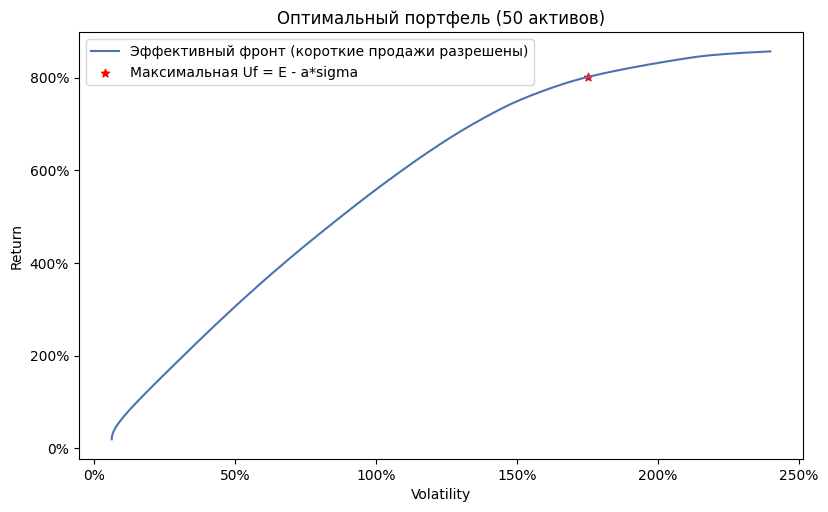

In [ ]:
figure(figsize=(8, 5), dpi=100)


ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=300, show_assets=False)
ef500 = EfficientFrontier(mu50, Sigma50, weight_bounds=(-1,1))

ef500.set_weights(w_50)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r")

# ef500.max_quadratic_utility(risk_aversion=a)
# ret_tangent, std_tangent, _ = ef500.portfolio_performance()
# ax.scatter(std_tangent, ret_tangent, marker="*", c="g")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи разрешены)', 'Максимальная Uf = E - a*sigma','Максимальная Квадратичная Uf']);
ax.set_title('Оптимальный портфель (50 активов)');

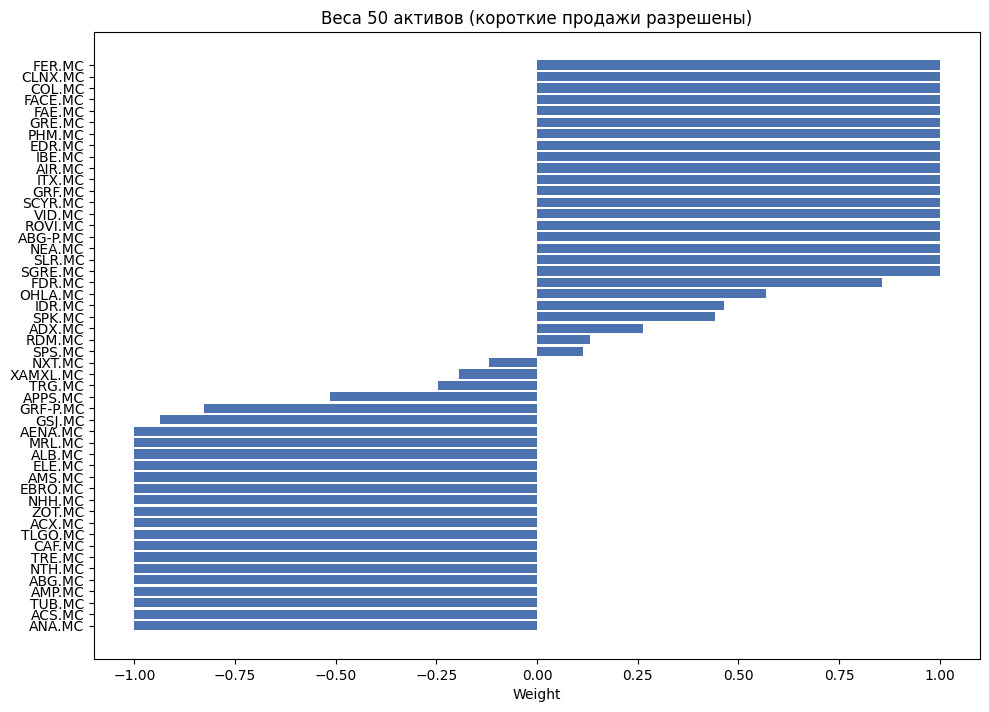

In [ ]:
figure(figsize=(10, 7), dpi=100)
ax=pplt.plot_weights(w_50);
ax.set_title('Веса 50 активов (короткие продажи разрешены)');

SPS.MC - Service Point Solutions (предоставляет услуги документооборота и цифровой репрографии)

RDM.MC - Reno De Medici (Контейнерные перевозки и упаковка)

ADX.MC - Audax Renovables (разработчик и производитель возобновляемой энергии)

SPK.MC - Solarpack Corporacion Tecnologica (предоставляет услуги по строительству, развитию и управлению солнечными электростанциями)

IDR.MC - Indra Sistemas (испанский концерн в сфере разработки информационных технологий, автоматизированного тестового оборудования и вооружения)

OHLA.MC - Obrascón Huarte Lain (испанская многонациональная строительная и гражданская компания)

FDR.MC - Fluidra (компания, специализирующейся в секторе бассейнов и велнеса (англ. wellness — «хорошее здоровье» или «благополучие»))

In [ ]:
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_50, log_returns=True)).dot(chosen_portf_weigths))
param_VaR, hist_VaR

(0.1487451535935963, 0.13439389311438732)

In [ ]:
result.loc['Max UF 50 Shorts Allowed', 'VaR'] = hist_VaR
result.loc['Max UF 50 Shorts Allowed', 'Return (Annualised)'] = rets[max_ind]
result.loc['Max UF 50 Shorts Allowed', 'Std (Annualised)'] = sigmas[max_ind]

# Задание 4

## 10 активов (короткие продажи запрещены)

In [ ]:
ef = EfficientFrontier(mu10, Sigma10, weight_bounds=(0, 1),)
cl_obj = CLA(mu10, Sigma10, weight_bounds=(0, 1),)
rets, sigmas, weights = cl_obj.efficient_frontier(points=8000, )
rets = np.array(rets)
sigmas = np.array(sigmas)
weights = np.array(weights)

In [ ]:
a = 1.5
rets = np.array(rets)
sigmas = np.array(sigmas)
util_fun = rets - a*sigmas
max_ind, max_val = util_fun.argmax(), util_fun.max()
max_ind, max_val

(1718, 0.5749854093336608)

In [ ]:
chosen_portf_weigths = weights[max_ind]
chosen_portf_weigths = [x for l in chosen_portf_weigths for x in l]

ef50=EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))
w_10=EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1)).min_volatility()
for name, weight in zip(w_10, chosen_portf_weigths):
  w_10[name] = weight

ef50.set_weights(w_10)
print(w_10)

OrderedDict([('CLNX.MC', 0.1593269574428517), ('FACE.MC', 0.46939949952938387), ('GRE.MC', 0.37127354302776466), ('ROVI.MC', 0.0), ('NEA.MC', 2.0338796456631658e-17), ('OHLA.MC', 0.0), ('NXT.MC', 0.0), ('SPS.MC', 0.0), ('XAMXL.MC', 0.0), ('ABG.MC', 0.0)])


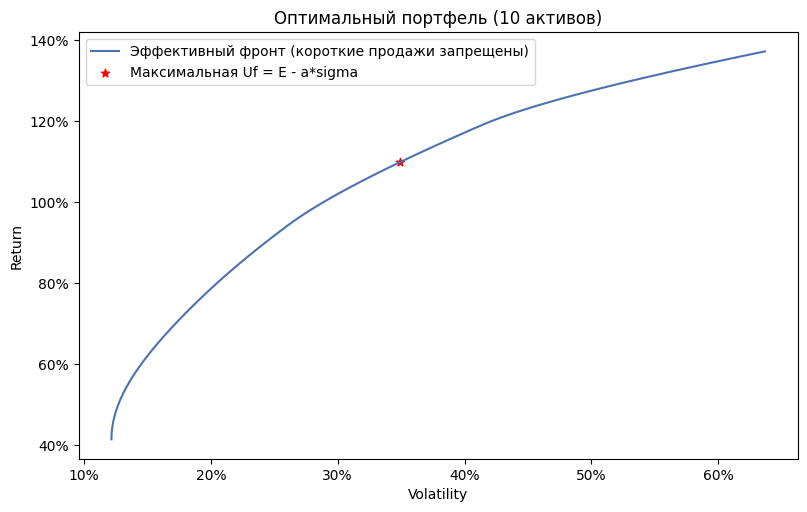

In [ ]:
figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=300, show_assets=False)
ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))

ef500.set_weights(w_10)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r")

# ef500.max_sharpe(risk_free_rate=0.015)
# ret_tangent, std_tangent, _ = ef500.portfolio_performance()
# ax.scatter(std_tangent, ret_tangent, marker="*", c="g")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи запрещены)', 'Максимальная Uf = E - a*sigma']);
ax.set_title('Оптимальный портфель (10 активов)');

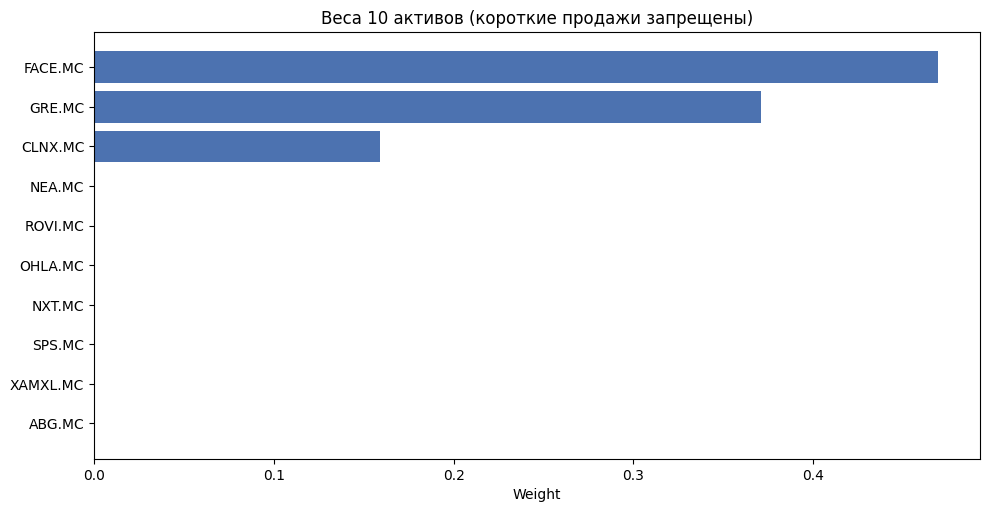

In [ ]:
figure(figsize=(10, 5), dpi=100)
ax=pplt.plot_weights(w_10);
ax.set_title('Веса 10 активов (короткие продажи запрещены)');

CLNX.MC - Cellnex Telecom (компания по предоставлению инфраструктуры и услуг беспроводной связи)

FACE.MC - Facephi Biometria (разработка и маркетинг программного обеспечения для распознавания лиц)

GRE.MC - Grenergy Renovables (разработчик и производитель возобновляемой энергии)

In [ ]:
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_10, log_returns=True)).dot(chosen_portf_weigths))
param_VaR, hist_VaR

(0.03156875729209375, 0.023869994798115357)

In [ ]:
result.loc['Max UF 10 Shorts Not Allowed', 'VaR'] = hist_VaR
result.loc['Max UF 10 Shorts Not Allowed', 'Return (Annualised)'] = rets[max_ind]
result.loc['Max UF 10 Shorts Not Allowed', 'Std (Annualised)'] = sigmas[max_ind]

## 10 активов (короткие продажи разрешены)

In [ ]:
ef = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1),)
cl_obj = CLA(mu10, Sigma10, weight_bounds=(-1, 1),)
rets, sigmas, weights = cl_obj.efficient_frontier(points=8000, )
rets = np.array(rets)
sigmas = np.array(sigmas)
weights = np.array(weights)

In [ ]:
a = 1.5
rets = np.array(rets)
sigmas = np.array(sigmas)
util_fun = rets - a*sigmas
max_ind, max_val = util_fun.argmax(), util_fun.max()
max_ind, max_val

(4126, 1.2013568457241048)

In [ ]:
chosen_portf_weigths = weights[max_ind]
chosen_portf_weigths = [x for l in chosen_portf_weigths for x in l]

ef50=EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1))
w_10=EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1)).min_volatility()
for name, weight in zip(w_10, chosen_portf_weigths):
  w_10[name] = weight

ef50.set_weights(w_10)
print(w_10)

OrderedDict([('CLNX.MC', 1.0), ('FACE.MC', 1.0), ('GRE.MC', 1.0), ('ROVI.MC', 0.010061249480440897), ('NEA.MC', 0.19860930180290387), ('OHLA.MC', 0.07436993997687139), ('NXT.MC', -0.7867434876585343), ('SPS.MC', -0.10304792327060602), ('XAMXL.MC', -1.0), ('ABG.MC', -0.39324908033107464)])


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



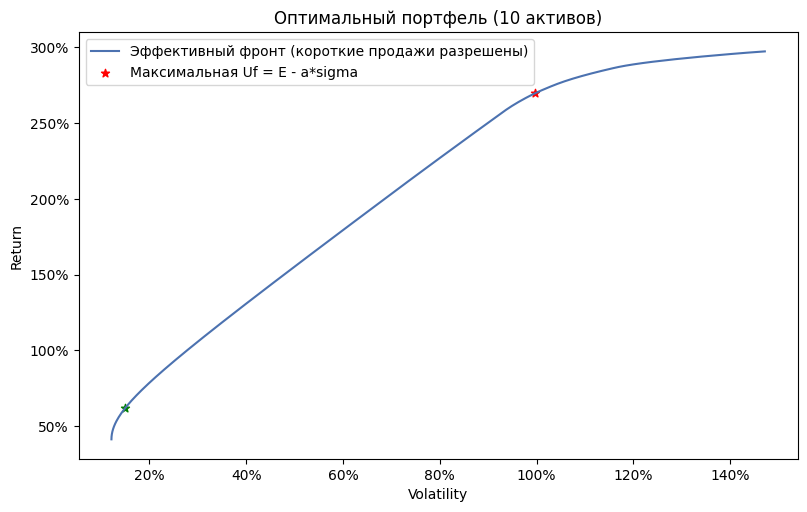

In [ ]:
figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=300, show_assets=False)
ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1, 1))

ef500.set_weights(w_10)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="r")

ef500.max_sharpe(risk_free_rate=0.015)
ret_tangent, std_tangent, _ = ef500.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", c="g")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи разрешены)', 'Максимальная Uf = E - a*sigma']);
ax.set_title('Оптимальный портфель (10 активов)');

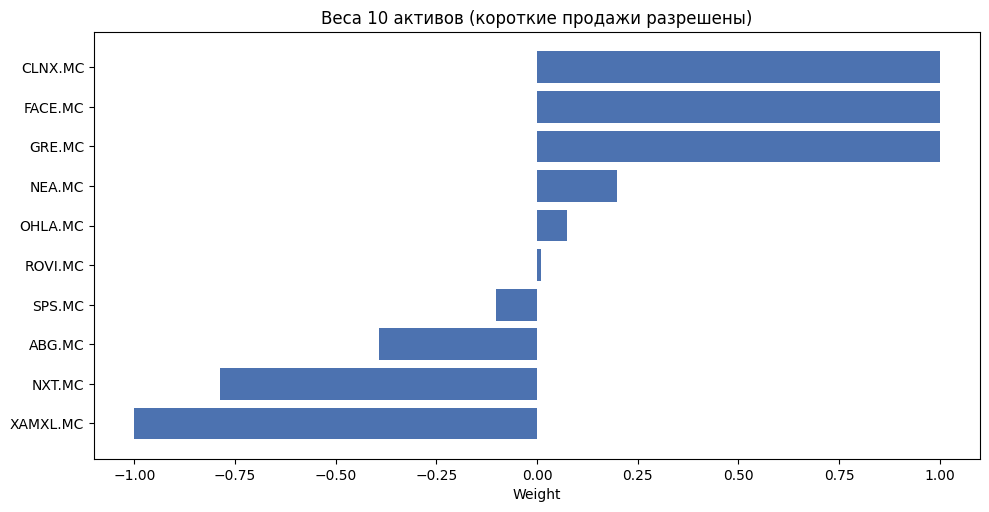

In [ ]:
figure(figsize=(10, 5), dpi=100)
ax=pplt.plot_weights(w_10);
ax.set_title('Веса 10 активов (короткие продажи разрешены)');

CLNX.MC - Cellnex Telecom (компания по предоставлению инфраструктуры и услуг беспроводной связи)

FACE.MC - Facephi Biometria (разработка и маркетинг программного обеспечения для распознавания лиц)

GRE.MC - Grenergy Renovables (разработчик и производитель возобновляемой энергии)

ROVI.MC - Laboratorios Farmaceuticos (фармацевтическая комания)

NEA.MC - Nicolás Correa (производство фрезерных станков)

OHLA.MC - Obrascón Huarte Lain (испанская многонациональная строительная и гражданская компания)

NXT.MC - Nueva Expresión Textil (текстильная промышленность)

SPS.MC - Service Point Solutions (предоставляет услуги документооборота и цифровой репрографии)

XAMXL.MC - América Móvil (телекоммуникационный холдинг)

ABG.MC - Abengoa (компания, работающая в сфере зеленой инфраструктуры, энергетики и водоснабжения)

In [ ]:
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_10, log_returns=True)).dot(chosen_portf_weigths))
param_VaR, hist_VaR

(0.09200571034452827, 0.07587669526548659)

In [ ]:
result.loc['Max UF 10 Shorts Allowed', 'VaR'] = hist_VaR
result.loc['Max UF 10 Shorts Allowed', 'Return (Annualised)'] = rets[max_ind]
result.loc['Max UF 10 Shorts Allowed', 'Std (Annualised)'] = sigmas[max_ind]

# Задание 5


In [ ]:
ef10 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))
sharpe_pfolio=ef10.max_sharpe(risk_free_rate=0.015) 
sharpe_pwtSC=ef10.clean_weights()
print(sharpe_pwtSC)
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_10, log_returns=True)).dot(list(sharpe_pwtSC.values())))
param_VaR, hist_VaR

OrderedDict([('CLNX.MC', 0.29862), ('FACE.MC', 0.12539), ('GRE.MC', 0.12447), ('ROVI.MC', 0.15816), ('NEA.MC', 0.11127), ('OHLA.MC', 0.01522), ('NXT.MC', 0.07303), ('SPS.MC', 0.02326), ('XAMXL.MC', 0.04716), ('ABG.MC', 0.02343)])


(0.012961693622596266, 0.011326187074192723)

In [ ]:
result.loc['Sharp Portfolio Shorts Not Allowed', 'VaR'] = hist_VaR
result.loc['Sharp Portfolio Shorts Not Allowed', 'Return (Annualised)'] = ef10.portfolio_performance()[0]
result.loc['Sharp Portfolio Shorts Not Allowed', 'Std (Annualised)'] = ef10.portfolio_performance()[1]

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



In [ ]:
ef10 = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1,1))
sharpe_pfolio=ef10.max_sharpe(risk_free_rate=0.015)
sharpe_pwt11=ef10.clean_weights()
print(sharpe_pwt11)
param_VaR, hist_VaR = calc_var((returns_from_prices(df_best_10, log_returns=True)).dot(list(sharpe_pwt11.values())))
param_VaR, hist_VaR

OrderedDict([('CLNX.MC', 0.29862), ('FACE.MC', 0.12539), ('GRE.MC', 0.12447), ('ROVI.MC', 0.15816), ('NEA.MC', 0.11127), ('OHLA.MC', 0.01522), ('NXT.MC', 0.07303), ('SPS.MC', 0.02326), ('XAMXL.MC', 0.04716), ('ABG.MC', 0.02343)])


(0.012961693622596266, 0.011326187074192723)

In [ ]:
result.loc['Sharp Portfolio Shorts Allowed', 'VaR'] = hist_VaR
result.loc['Sharp Portfolio Shorts Allowed', 'Return (Annualised)'] = ef10.portfolio_performance()[0]
result.loc['Sharp Portfolio Shorts Allowed', 'Std (Annualised)'] = ef10.portfolio_performance()[1]

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



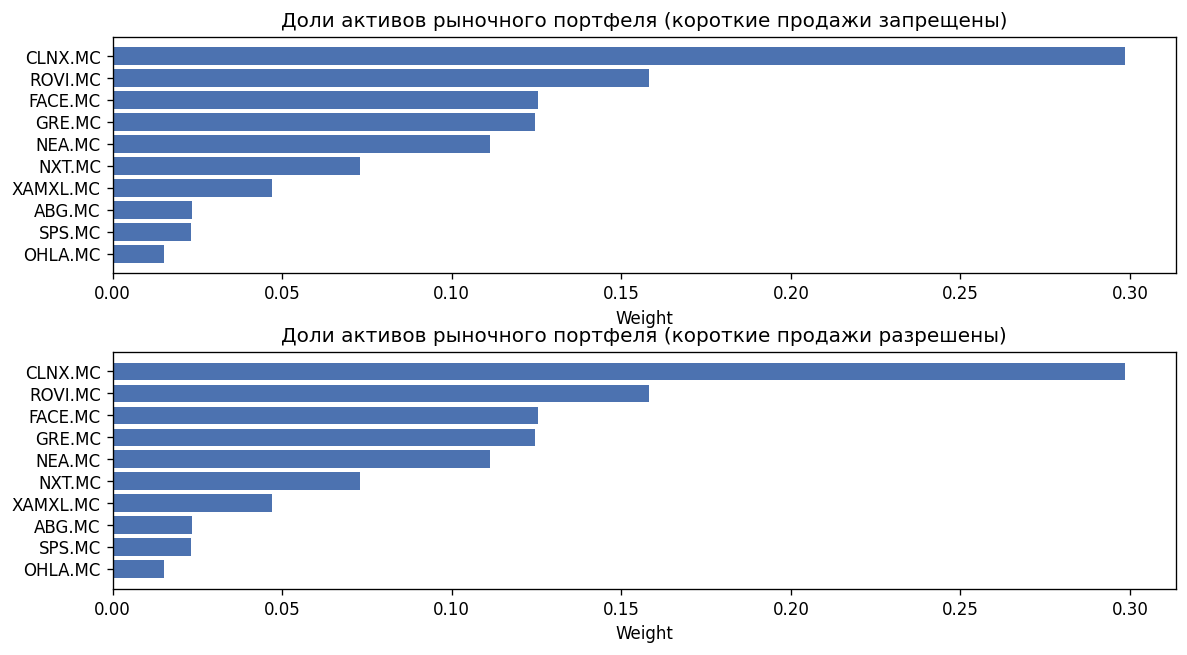

In [ ]:
fig, axs = plt.subplots(2,figsize=(10, 5), dpi=120)
pplt.plot_weights(sharpe_pwtSC,ax=axs[0])
pplt.plot_weights(sharpe_pwt11,ax=axs[1])
axs[0].set_title('Доли активов рыночного портфеля (короткие продажи запрещены)')
axs[1].set_title('Доли активов рыночного портфеля (короткие продажи разрешены)')
plt.subplots_adjust(bottom = 0.05)

CLNX.MC - Cellnex Telecom (компания по предоставлению инфраструктуры и услуг беспроводной связи)

FACE.MC - Facephi Biometria (разработка и маркетинг программного обеспечения для распознавания лиц)

GRE.MC - Grenergy Renovables (разработчик и производитель возобновляемой энергии)

ROVI.MC - Laboratorios Farmaceuticos (фармацевтическая комания)

NEA.MC - Nicolás Correa (производство фрезерных станков)

OHLA.MC - Obrascón Huarte Lain (испанская многонациональная строительная и гражданская компания)

NXT.MC - Nueva Expresión Textil (текстильная промышленность)

SPS.MC - Service Point Solutions (предоставляет услуги документооборота и цифровой репрографии)

XAMXL.MC - América Móvil (телекоммуникационный холдинг)

ABG.MC - Abengoa (компания, работающая в сфере зеленой инфраструктуры, энергетики и водоснабжения)

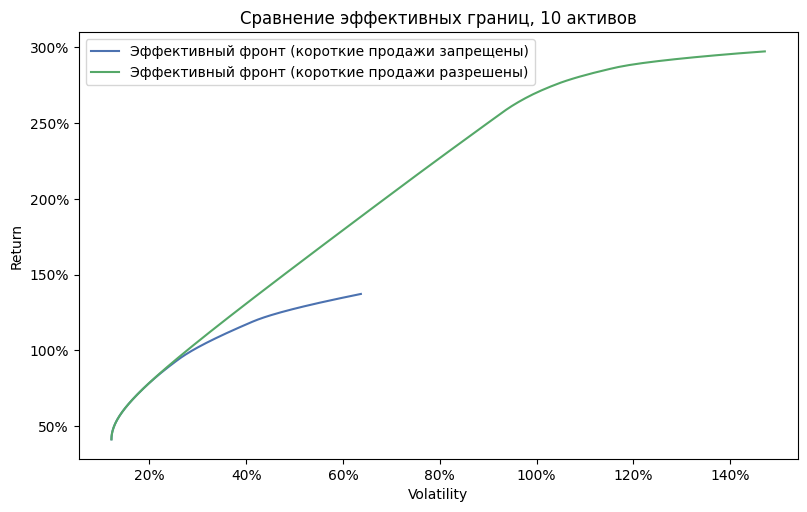

In [ ]:
figure(figsize=(8, 5), dpi=100)

ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(0,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ef500 = EfficientFrontier(mu10, Sigma10, weight_bounds=(-1,1))
ax = pplt.plot_efficient_frontier(ef500, showfig = False, points=200, show_assets=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Эффективный фронт (короткие продажи запрещены)', 'Эффективный фронт (короткие продажи разрешены)'])
ax.set_title('Сравнение эффективных границ, 10 активов');

Эффективные границы с разрешенными и запрещенными короткими продажами совпадают в области оптимального портфеля по Шарпу (Снизу слева на графике).

# Результаты

In [ ]:
result

,Return (Annualised),Std (Annualised),VaR
Max UF 50 Shorts Allowed,8.01483,1.75143,0.134394
Max UF 50 Shorts Not Allowed,1.1481,0.34711,0.0232264
Max UF 10 Shorts Allowed,2.69756,0.997468,0.0758767
Max UF 10 Shorts Not Allowed,1.0982,0.348808,0.02387
Sharp Portfolio Shorts Allowed,0.618127,0.149568,0.0113262
Sharp Portfolio Shorts Not Allowed,0.618127,0.149568,0.0113262
